In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Found 40168 images belonging to 6 classes.
Found 90 images belonging to 6 classes.

### LEVEL1 ###
pretrained network:
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1301 (Activation)    (None, 165, 165, 96) 0           stem_bn1

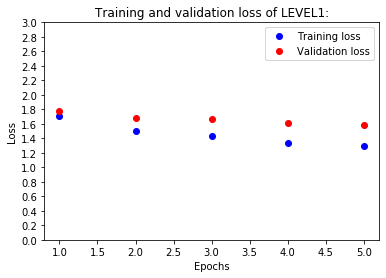

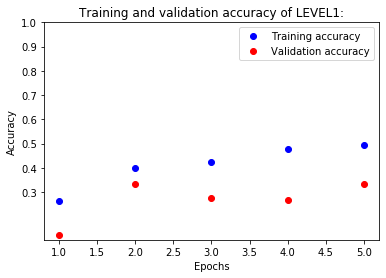


### LEVEL1 Training finished successfully ###

### LEVEL2 ###

Loading trained weights from ./drive/My Drive/trained_models/trained_weights/weights_temp.h5 ...

trainable layers before unfreezing the base network up to normal_add_1_15:  510
trainable layers after the base network unfreezed from layer normal_add_1_15:  71

LEVEL2 Model after unfreezing the base network

### Validating ... 
Validation Results before training unfreeze layers and trained densely connected layers:
Validation loss: 1.5891958898968166 , Validation accuracy: 0.3333333333333333 


### Level2 Training ... 
Epoch 1/5
32/32 [==============================] - 709s 22s/step - loss: 1.1244 - acc: 0.5806 - val_loss: 1.3073 - val_acc: 0.6000
Epoch 2/5
32/32 [==============================] - 718s 22s/step - loss: 1.0092 - acc: 0.6157 - val_loss: 1.1990 - val_acc: 0.6778
Epoch 3/5
32/32 [==============================] - 743s 23s/step - loss: 0.9456 - acc: 0.6240 - val_loss: 1.1274 - val_acc: 0.6889
Epoch 4/5
32/32 [==

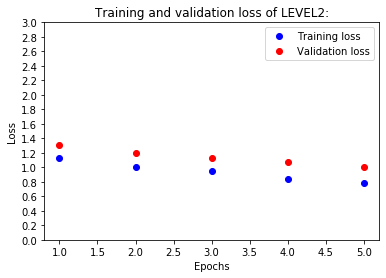

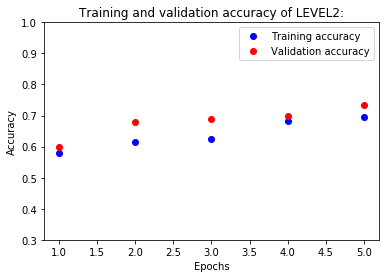


###LEVEL2 Training finished successfully ###
Time elapsed in minutes:  139.89685256493337


In [0]:
# Imports
import os
from keras.applications import NASNetLarge
from keras import models, layers, optimizers, backend
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer

def main():
    start = timer()
    level1()  # Training the classifier only
    level2()
    end = timer()
    print("Time elapsed in minutes: ", ((end - start)/60))

# Setting Parameters ##################################################################
# image settings
img_height,img_width = 331, 331  # For NASNetLarge

# classes
classnames = ["Background", "BMP2", "Buk-M1-2", "T14", "T90", "ZSU23"]
classes = len(classnames)

# path settings
path = './drive/My Drive/'
dataset_path = './drive/My Drive/RuTanks7000_v1/'
weights_path = path+'trained_models/trained_weights/weights_temp.h5'
model_path = path+'trained_models/RuTanks7000_v1_'
TensorBoardLogDir = path+'logs'

nbrTrainImages = 7000  # per class
nbrTestImages = 0  # Value gets accurate after counting (Total Number of test images)
for ImagesClass in os.listdir(dataset_path+'test/'):
    nbrTestImages += len(os.listdir(dataset_path+'test/'+ImagesClass))

# unfreezing the base network up to a specific layer in Level2:
freezeUptoLayer = "normal_add_1_15"   # NASNetLarge

# hyperparameters
learning_rate = 0.0002  # Learning_rate in Level 2 = learning_rate/10
lr_decay = 0.0001
batch = 64
fcLayer1 = 16
dropout = 0.5

epochsL1 = 5
patiencel1 = 1
factorL1 = 0.5

epochsL2 = 5
patiencel2 = 1
factorL2 = 0.5

verbose_train = 1

# datagenerators https://keras.io/preprocessing/image/
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    dataset_path+'train',
    target_size=(img_height, img_width),
    batch_size=batch,
    shuffle=True,
    classes=classnames,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    dataset_path+'test',
    target_size=(img_height, img_width),
    batch_size=1,
    shuffle=True,
    classes=classnames,
    class_mode='categorical')

# function to plot results of model performance
def plot(h,t,e):
    history_dict = h[0]
    loss_values = history_dict['loss']
    validation_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    validation_acc_values = history_dict['val_acc']
    epochs_range = range(1, e + 1)

    # Plotting Training and Validation loss of the corresponding Model
    plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
    plt.plot(epochs_range, validation_loss_values, 'ro', label='Validation loss')
    plt.title('Training and validation loss of ' + t)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0, 3.1, step=0.2))
    plt.legend()
    plt.show()

    # Plotting Training and Validation accuracy of the corresponding Model
    plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
    plt.plot(epochs_range, validation_acc_values, 'ro', label='Validation accuracy')
    plt.title('Training and validation accuracy of ' + t)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0.3, 1.1, step=0.1))
    plt.legend()
    plt.show()


# LEVEL1 - Training of densely connected layers
def level1():
    # Building the model using the pretrained model
    conv_base1 = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    print("\n### LEVEL1 ###\npretrained network:")
    conv_base1.summary()
    model = models.Sequential()
    model.add(conv_base1)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(fcLayer1, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(classes, activation='softmax'))

    # freezing the base network
    print("trainable layers bevor freezing:", int(len(model.trainable_weights)/2)) # weights = weights + bias = 2 pro layer
    conv_base1.trainable = False
    print("trainable layers after freezing:", int(len(model.trainable_weights)/2))
    print("\npretrained network + densely connected classifier")
    model.summary()

    # training the added layers only
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])

    print("\n### Level1 Training ... ")
    # training the model
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=(nbrTrainImages * classes) // (batch*20),
        epochs=epochsL1,
        validation_data=test_generator,
        validation_steps=nbrTestImages,
        verbose=verbose_train)

    history_val1 = [history.history]  # saving all results of the final test
    plot(history_val1, "LEVEL1:", epochsL1)
    print("\n### LEVEL1 Training finished successfully ###")
    model.save('l1.h5')

# LEVEL2 - Training pretrained network and trained densely connected layers
def level2():
    print("\n### LEVEL2 ###")
    conv_base2 = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    model2 = models.Sequential()
    model2.add(conv_base2)
    model2.add(layers.GlobalAveragePooling2D())
    model2.add(layers.Dense(fcLayer1, activation='relu'))
    model2.add(layers.Dropout(dropout))
    model2.add(layers.Dense(classes, activation='softmax'))

    print("\nLoading trained weights from " + weights_path + " ...")
    model2.load_weights("l1.h5")

    # unfreezing the base network up to a specific layer:
    if freezeUptoLayer == "":
        conv_base2.trainable = True
        print ("\ntrainable layers: ",int(len(model2.trainable_weights) / 2))
    else:
        print("\ntrainable layers before unfreezing the base network up to " + freezeUptoLayer + ": ",int(len(model2.trainable_weights) / 2))  # weights = weights + bias = 2 pro layer
        conv_base2.trainable = True
        set_trainable = False
        for layer in conv_base2.layers:
            if layer.name == freezeUptoLayer: set_trainable = True
            if set_trainable: layer.trainable = True
            else: layer.trainable = False
        print("trainable layers after the base network unfreezed from layer " + freezeUptoLayer + ": ", int(len(model2.trainable_weights)/2))

    print("\nLEVEL2 Model after unfreezing the base network")
    model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate/10, decay=lr_decay), metrics=['acc'])
    print ("\n### Validating ... ")

    val_loss, val_acc = model2.evaluate_generator(test_generator, steps=nbrTestImages, verbose=0)
    print('Validation Results before training unfreeze layers and trained densely connected layers:\nValidation loss:',val_loss,",",'Validation accuracy:', val_acc, "\n")

    print ("\n### Level2 Training ... ")
    history = model2.fit_generator(
        train_generator,
        steps_per_epoch=(nbrTrainImages * classes) // (batch*20),
        epochs=epochsL2,
        validation_data=test_generator,
        validation_steps=nbrTestImages,
        verbose=verbose_train)

    history_val2 = [history.history]  # saving all results of the final test
    plot(history_val2, "LEVEL2:", epochsL2)
    print("\n###LEVEL2 Training finished successfully ###")

main()

It should be noted that the training time was taking forever, so many parameters such as epochs were decreased. Therefore, not much was learned by the network. Running the network longer would result in better accuracy scores.